In [1]:
import pandas as pd
import json

from info import NFTFI_QUERY_ID, FP_QUERY_ID, CONTRACT_ADDRESS
from fetch import fetch_table
from parse import parse_stringfied_float, parse_loan_type, parse_loan_start_date, to_inverse_slashed, to_days, to_liquidated_mask


def loadNFTfi():
    loan_term_df = fetch_table(NFTFI_QUERY_ID['NFTfi_LoanStarted'])
    loan_term_df = loan_term_df[loan_term_df["loanDuration"] > 1000]
    
    loan_liquidated = fetch_table(NFTFI_QUERY_ID['NFTfi_LoanLiquidated'])["loanId"].astype(float)
    loan_liquidated = to_liquidated_mask(loan_term_df["loanId"], loan_liquidated)

    # Compute APR
    loan_amount = parse_stringfied_float(loan_term_df["loanPrincipalAmount"])
    loan_max_amount = parse_stringfied_float(loan_term_df["maximumRepaymentAmount"])
    loan_days = to_days(loan_term_df["loanDuration"])
    apr = (100 * 365 * ((loan_max_amount - loan_amount) / loan_amount) / loan_days).round(decimals=2)
    loan_start_date = parse_loan_start_date(loan_term_df["loanStartTime"])
    return pd.DataFrame({
        "borrower": to_inverse_slashed(loan_term_df["borrower"]),
        "lender": to_inverse_slashed(loan_term_df["lender"]),
        "nftCollateralContract": to_inverse_slashed(loan_term_df["nftCollateralContract"]),
        "nftCollateralId": loan_term_df["nftCollateralId"].astype(float).astype(int),
        "loanDuration": loan_days,
        "loanStartTime":loan_start_date,
        "loanPrincipalAmount": loan_amount,
        "maximumRepaymentAmount": loan_max_amount,
        "apr": apr,
        "loanERC20Denomination": parse_loan_type(to_inverse_slashed(loan_term_df["loanERC20Denomination"])),
        "loanLiquidated": loan_liquidated,
    })

        
def loadDirectFixedOffer():
    loan_terms = fetch_table(NFTFI_QUERY_ID['DirectLoanFixedOffer_LoanStarted'])
    loan_liquidated = fetch_table(NFTFI_QUERY_ID['DirectLoanFixedOffer_LoanLiquidated'])["loanId"].astype(float)
    loan_liquidated = to_liquidated_mask(loan_terms["loanId"], loan_liquidated)
    loan_term_df = pd.DataFrame()
    for pd_row in loan_terms["loanTerms"]:
        json_row = json.loads(pd_row)
        loan_term_df = loan_term_df.append(json_row, ignore_index=True)

    # Compute APR
    loan_amount = parse_stringfied_float(loan_term_df["loanPrincipalAmount"])
    loan_max_amount = parse_stringfied_float(loan_term_df["maximumRepaymentAmount"])
    loan_days = to_days(loan_term_df["loanDuration"])
    apr = (100 * 365 * ((loan_max_amount - loan_amount) / loan_amount) / loan_days).round(decimals=2)


    gatherd_loan_term_df = pd.DataFrame({
        "borrower": to_inverse_slashed(loan_terms["borrower"]),
        "lender": to_inverse_slashed(loan_terms["lender"]),
        "nftCollateralContract": to_inverse_slashed(loan_term_df["nftCollateralContract"]),
        "nftCollateralId": loan_term_df["nftCollateralId"].astype(float).astype(int),
        "loanDuration": loan_days,
        "loanStartTime": parse_loan_start_date(loan_term_df["loanStartTime"]),
        "loanPrincipalAmount": loan_amount,
        "maximumRepaymentAmount": loan_max_amount,
        "apr": apr,
        "loanERC20Denomination": parse_loan_type(to_inverse_slashed(loan_term_df["loanERC20Denomination"])),
        "loanLiquidated": loan_liquidated
    })
    
    # remove weird loan_term
    gatherd_loan_term_df = gatherd_loan_term_df[loan_term_df["loanDuration"] > 1000]
    return gatherd_loan_term_df        

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from info import CONTRACT_ADDRESS, FP_QUERY_ID, TRADES_QUERY_ID


def computeProfitAfterSale(loan_info: pd.Series, contract_name: str):
    trade_info = fetch_table(TRADES_QUERY_ID[contract_name])
    liquidated_loan_info = loan_info[
        (loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[contract_name]) * loan_info["loanLiquidated"]
    ]
    nft_token_id = trade_info["nft_token_ids_array"].apply(lambda x: x[0] if len(x) else float("nan")).astype(float)
    sold_datetime = trade_info["block_time"].apply(pd.to_datetime).dt.date
    
    profits = []
    for _, liquidated_loan in liquidated_loan_info.iterrows():
        related_trades = trade_info[
            (nft_token_id == liquidated_loan["nftCollateralId"])
            * (sold_datetime > liquidated_loan["loanStartTime"])
        ]

        if len(related_trades) > 0:
            related_trade = related_trades.iloc[0]
            sold_price = related_trade["original_amount"]
            principal_money = liquidated_loan["loanPrincipalAmount"]

            profit = sold_price / principal_money
            profits.append(profit)

    profits = pd.Series(profits)
    print(f"{contract_name}: #Liquidated {len(liquidated_loan_info)}, #Sold {len(profits)}, Ratio: {len(profits)/float(len(liquidated_loan_info))} , Average Profit {profits.mean()*100:2f}%, Median Profit {profits.median()*100:2f}%")


def computeLTV(loan_info: pd.Series, contract_name: str):
    loan_info = loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[contract_name]]
    floor_price = fetch_table(FP_QUERY_ID[contract_name])
    day = floor_price["day"].apply(lambda x: x[:10])
    fp = floor_price["floor_price"].astype(float)
    floor_price = pd.Series(fp.values,index=day).to_dict()
    
    loan_info = loan_info[loan_info["loanERC20Denomination"]=="wETH"]
    ltvs = []
    for d, a in zip(loan_info["loanStartTime"], loan_info["loanPrincipalAmount"]):
        s = ("%04d-%02d-%02d") % (d.year, d.month, d.day)
        if s in floor_price:
            fp = floor_price[s]
            ltv = float(a) / float(fp)
            ltvs.append(ltv)
        else:
            ltvs.append(float('nan'))

    ltvs =  pd.Series(ltvs)
    print(f'{contract_name} LTV Avg {ltvs.mean()}, Median, {ltvs.median()}, Min {ltvs.min()}, Max {ltvs.max()}')

    plt.title(f"{contract_name} LTV Distribution")
    plt.hist(ltvs, bins=20, range=(0, 2))
    plt.show()


def count_holder(loan_info: pd.Series, contract_name: str):
    from collections import defaultdict

    loan_info = loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[contract_name]]
    counter = defaultdict(set)  

    for holder_account, nft_address in zip(loan_info["borrower"], loan_info["nftCollateralId"]):
        counter[holder_account].add(nft_address)

    counter = {k: len(v) for k, v in counter.items()}
    histogram = list(counter.values())
   
    plt.title(f"{contract_name} Num NFT Holding Distribution")
    plt.hist(histogram, bins=list(range(30)))
    plt.show()


# 지표를 뽑자
def print_stat(loan_info: pd.Series, contract_name: str):
    # Average APR BAYC
    selected_loan = loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[contract_name]]
    print(f'{contract_name} Unique Loan. {len(selected_loan)}')
    print(f'{contract_name} Loan Total. {selected_loan[selected_loan["loanERC20Denomination"]=="wETH"]["maximumRepaymentAmount"].sum()} wETH')
    print(f'{contract_name} APR avg. {selected_loan["apr"].mean()}, median {selected_loan["apr"].median()}, min {selected_loan["apr"].min()}, max {selected_loan["apr"].max()}')
    print(f'{contract_name} Unique Loan Holder. {len(selected_loan["borrower"].unique())}')
    print(f'{contract_name} Unique NFT. {len(selected_loan["nftCollateralId"].unique())}')
    print(f'{contract_name} Loan Duration avg. {selected_loan["loanDuration"].mean()}, median {selected_loan["loanDuration"].median()}, min {selected_loan["loanDuration"].min()}, max {selected_loan["loanDuration"].max()}')
    print(f'{contract_name} Loan Liquidation Ratio {selected_loan["loanLiquidated"].astype(float).sum() / len(selected_loan)}, average liquidation ratio {loan_info["loanLiquidated"].astype(float).sum() / len(loan_info)}')
    print(f'{contract_name} Loan Principal Amount Average {selected_loan["loanPrincipalAmount"].mean()}')

    computeLTV(selected_loan, contract_name)
    count_holder(selected_loan, contract_name)
    computeProfitAfterSale(selected_loan, contract_name)

In [3]:
import pandas as pd

loan_info_b = loadNFTfi()
loan_info_a = loadDirectFixedOffer()
loan_info = pd.concat([loan_info_a, loan_info_b], axis=0)

## BAYC Statistics

bayc Unique Loan. 426
bayc Loan Total. 16196.908741000001 wETH
bayc APR avg. 44.18058685446014, median 37.0, min 0.0, max 208.57
bayc Unique Loan Holder. 122
bayc Unique NFT. 207
bayc Loan Duration avg. 46.84272300469483, median 30.0, min 3.0, max 120.0
bayc Loan Liquidation Ratio 0.035211267605633804, average liquidation ratio 0.08231230984294055
bayc Loan Principal Amount Average 9167.966203250939
bayc LTV Avg 0.550147803027146, Median, 0.5504031902705562, Min 0.029565217391304348, Max 1.5145395799676897


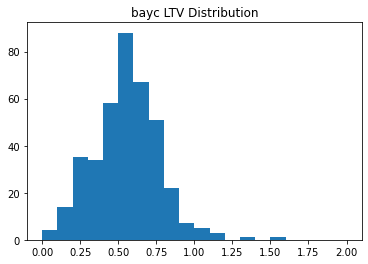

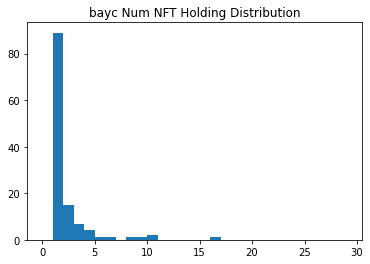

bayc: #Liquidated 15, #Sold 2, Ratio: 0.13333333333333333 , Average Profit 206.294167%, Median Profit 206.294167%


In [24]:
print_stat(loan_info, "bayc")

## Crypto Punks

cryptopunks Unique Loan. 430
cryptopunks Loan Total. 1441.508469 wETH
cryptopunks APR avg. 14.04786046511628, median 10.0, min 0.08, max 130.36
cryptopunks Unique Loan Holder. 35
cryptopunks Unique NFT. 253
cryptopunks Loan Duration avg. 62.73953488372093, median 90.0, min 7.0, max 90.0
cryptopunks Loan Liquidation Ratio 0.06279069767441861, average liquidation ratio 0.08231230984294055
cryptopunks Loan Principal Amount Average 65594.36697674418
cryptopunks LTV Avg 0.6706489755388834, Median, 0.6105900950337747, Min 0.0014410986936440342, Max 1.59566829247536


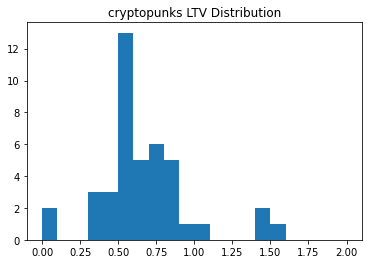

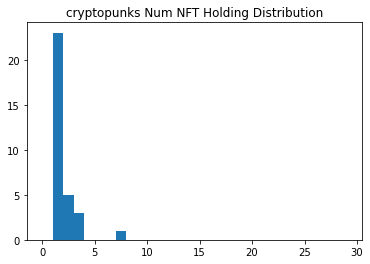

cryptopunks: #Liquidated 27, #Sold 0, Ratio: 0.0 , Average Profit nan%, Median Profit nan%


<ipython-input-23-d557da8f522b>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  profits = pd.Series(profits)


In [25]:
print_stat(loan_info, "cryptopunks")

## Doodles

doodles Unique Loan. 443
doodles Loan Total. 4411.024812767124 wETH
doodles APR avg. 46.41004514672689, median 40.0, min 0.0, max 108.0
doodles Unique Loan Holder. 125
doodles Unique NFT. 266
doodles Loan Duration avg. 40.419864559819416, median 30.0, min 1.0, max 120.0
doodles Loan Liquidation Ratio 0.05417607223476298, average liquidation ratio 0.08231230984294055
doodles Loan Principal Amount Average 602.6687105869074
doodles LTV Avg 0.7900054221944396, Median, 0.6687685105569886, Min 0.1400128428571078, Max 7.222222222222222


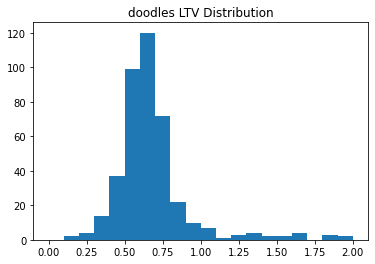

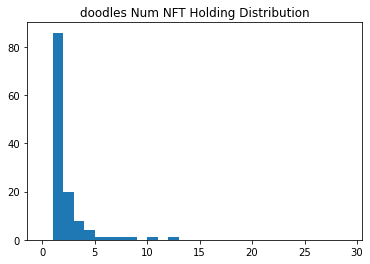

doodles: #Liquidated 24, #Sold 2, Ratio: 0.08333333333333333 , Average Profit 171.277778%, Median Profit 171.277778%


In [26]:
print_stat(loan_info, "doodles")

## World of Woman

worldofwomen Unique Loan. 539
worldofwomen Loan Total. 3501.800161712328 wETH
worldofwomen APR avg. 67.35022263450868, median 85.0, min 0.0, max 135.49
worldofwomen Unique Loan Holder. 88
worldofwomen Unique NFT. 205
worldofwomen Loan Duration avg. 32.20964749536178, median 30.0, min 1.0, max 120.0
worldofwomen Loan Liquidation Ratio 0.03525046382189239, average liquidation ratio 0.08231230984294055
worldofwomen Loan Principal Amount Average 109.50446333170503
worldofwomen LTV Avg 1.2920551693297904, Median, 0.9059274641227023, Min 0.12761506276150628, Max 9.030704394942806


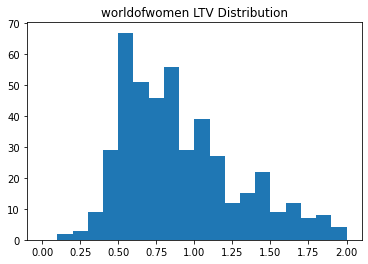

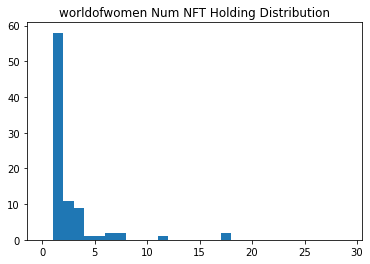

worldofwomen: #Liquidated 19, #Sold 4, Ratio: 0.21052631578947367 , Average Profit 99.567222%, Median Profit 89.000000%


In [27]:
print_stat(loan_info, "worldofwomen")

## Art Blocks2

artblock2 Unique Loan. 228
artblock2 Loan Total. 1550.292342 wETH
artblock2 APR avg. 38.16122807017542, median 25.0, min 0.1, max 228.02
artblock2 Unique Loan Holder. 68
artblock2 Unique NFT. 106
artblock2 Loan Duration avg. 36.99561403508772, median 30.0, min 7.0, max 90.0
artblock2 Loan Liquidation Ratio 0.05263157894736842, average liquidation ratio 0.08231230984294055
artblock2 Loan Principal Amount Average 588.813153372807
artblock2 LTV Avg 1.2900589957191275, Median, 0.8274527417159565, Min 0.0011235955056179774, Max 15.495867768595042


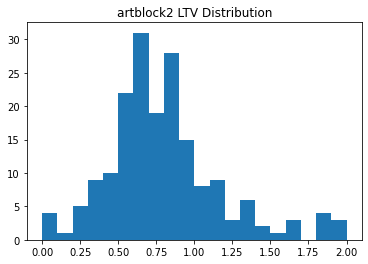

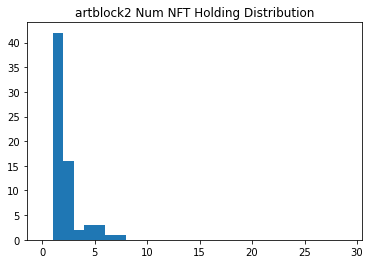

artblock2: #Liquidated 12, #Sold 2, Ratio: 0.16666666666666666 , Average Profit 540.625000%, Median Profit 540.625000%


In [28]:
print_stat(loan_info, "artblock2")

clonex Unique Loan. 303
clonex Loan Total. 3087.5789350958903 wETH
clonex APR avg. 55.82485148514848, median 45.0, min 10.0, max 120.49
clonex Unique Loan Holder. 93
clonex Unique NFT. 159
clonex Loan Duration avg. 38.9042904290429, median 30.0, min 3.0, max 90.0
clonex Loan Liquidation Ratio 0.10231023102310231, average liquidation ratio 0.08231230984294055
clonex Loan Principal Amount Average 262.1315895636963
clonex LTV Avg 0.7616647915349257, Median, 0.6561111111111111, Min 0.1320064334539606, Max 5.509641873278237


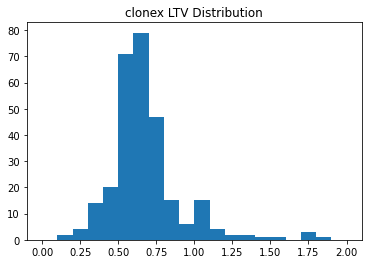

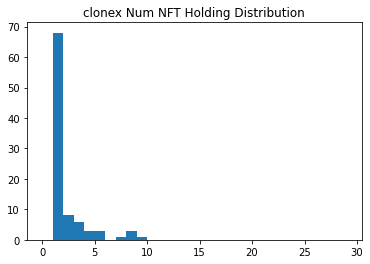

clonex: #Liquidated 31, #Sold 9, Ratio: 0.2903225806451613 , Average Profit 163.480653%, Median Profit 159.444444%


In [4]:
print_stat(loan_info, "clonex")

azuki Unique Loan. 225
azuki Loan Total. 2807.818741246575 wETH
azuki APR avg. 55.17884444444441, median 45.0, min 12.0, max 140.49
azuki Unique Loan Holder. 95
azuki Unique NFT. 139
azuki Loan Duration avg. 33.404444444444444, median 30.0, min 3.0, max 90.0
azuki Loan Liquidation Ratio 0.11555555555555555, average liquidation ratio 0.08231230984294055
azuki Loan Principal Amount Average 364.8389336133334
azuki LTV Avg 0.7433057667613215, Median, 0.6589262187088274, Min 0.3125, Max 2.6892430278884465


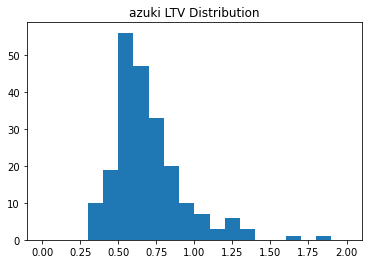

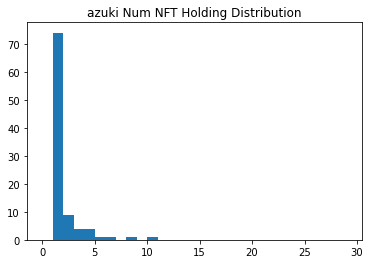

azuki: #Liquidated 26, #Sold 10, Ratio: 0.38461538461538464 , Average Profit 73.969666%, Median Profit 76.010760%


In [6]:
print_stat(loan_info, "azuki")